#### EarthQuake Mapping Using Sentinel 1 SLC

This demo uses Sentinel-1 SLC data, where pixels contain amplitude and phase. We take two SLCs (pre and post) around the Morocco earthquake: a reference image (often called “master”) and a secondary image (“slave”).

#### Study Area and Data
1. AOI =  "POLYGON((-11.30 32.60, -6.40 32.60, -6.40 29.20, -11.30 29.20, -11.30 32.60))" 
2. Data Source = Alaska Data Vertex, [L1 Single Look Complex](https://search.asf.alaska.edu/#/)


For this beginner demo, we stop at the wrapped interferogram (pretty rainbows). After this, you can continue to unwrap and convert to LOS displacement if you need numbers.

In [ ]:
# import functions from the package

from pysarflow import read_slc_product, burst_for_geometry, topsar_split, apply_orbit, back_geocoding,  \
save_product, interferogram, topsar_deburst, plot, multilooking, goldstein_phase_filtering,snaphu_export, \
snaphu_unwrapping, snaphu_import

##### Load Data

In [3]:
from pathlib import Path 

# Load the manifest alone or the whole SAFE folder 
 
master_safe_dir = Path("../../S1A_IW_SLC_03.SAFE") 
slave_safe_dir = Path("../../S1A_IW_SLC_15.SAFE")


#####  Pre Processing 

##### Read the master and slave data, define the aoi, apply topsar-split, orbit file, back-geocoding


1. TOPSAR-Split: Cuts each SLC down to the pieces that actually overlap, shrinking data and keeping only comparable bursts.

2. Apply Orbit-File: Attach precise satellite orbits to scenes.

3. Back-Geocoding (co-registration): Align the slave image onto the master image’s grid using the geometry and a DEM. For this to work the master and slave data must have the same swath.

4. Enhanced Spectral Diversity: Fine-tunes alignment between bursts using their overlap.

In [4]:
#Load the slc product  

master_data = read_slc_product("../../S1A_IW_SLC_03.SAFE") ## before the earthquake
slave_data =  read_slc_product("../../S1A_IW_SLC_15.SAFE")# after the earthquake

INFO: eu.esa.sar.commons.io.ImageIOFile: Using FileCacheImageInputStream


In [5]:

# Define AOI,  can be Shapely Point/Polygon, or WKT string, or bbox tuple (minlon,minlat,maxlon,maxlat)
aoi =  "POLYGON((-11.30 32.60, -6.40 32.60, -6.40 29.20, -11.30 29.20, -11.30 32.60))" #WKT string 


# get information about swath, bandname, bursts, first and last burst of the AOI
# the master and slave must have the same swath for a sensible coregistration to happen.
master = burst_for_geometry(master_data, master_safe_dir, aoi, subswath=None) # master
slave = burst_for_geometry(slave_data, slave_safe_dir, aoi, subswath=None) # slave

print(master) # sub-swath IW1
print(slave) # sub-swath IW1

#
topsar_master = topsar_split(master_data, master)
topsar_slave = topsar_split(slave_data, slave)

#apply orbit file
orbit_master = apply_orbit(topsar_master) 
orbit_slave = apply_orbit(topsar_slave) 

{'sub-swath': 'IW1', 'band_name': 'i_IW1_VH', 'linesPerBurst': 1498, 'numberOfBursts': 10, 'geom_type': 'Polygon', 'firstBurst': 4, 'lastBurst': 4}
{'sub-swath': 'IW1', 'band_name': 'i_IW1_VH', 'linesPerBurst': 1498, 'numberOfBursts': 10, 'geom_type': 'Polygon', 'firstBurst': 4, 'lastBurst': 4}

100% done.
TOPSAR-Split applied: IW1 bursts 4–4 (VH)

100% done.
TOPSAR-Split applied: IW1 bursts 4–4 (VH)

100% done.
Apply-Orbit-File: Sentinel Precise (Auto Download)

100% done.
Apply-Orbit-File: Sentinel Precise (Auto Download)


In [7]:
# you can save the output from each process into a local folder
save_product(orbit_master, "orbit_master")
# or
save_product(orbit_master, "orbit_slave")

Saving product to _results/orbit_master (BEAM-DIMAP)...
Product saved successfully.
Saving product to _results/orbit_slave (BEAM-DIMAP)...
Product saved successfully.


'_results/orbit_slave'

In [8]:

# back geocoding
geocoding = back_geocoding([orbit_master, orbit_slave])

Running Back-Geocoding...

100% done.
Back geocoding applied!


In [9]:
save_product(geocoding, "back_geocoding")


Saving product to _results/back_geocoding (BEAM-DIMAP)...
Product saved successfully.


'_results/back_geocoding'

##### Inteferogram: Combine the aligned complex images to get wrapped phase (the rainbow fringes).

Generate interferogram, save output and plot

In [10]:
# interferogram
interferogram = interferogram(geocoding)

# save the output
save_product(interferogram, "interferogram")

Creating interferogram ...

100% done.
Interferogram created!
Saving product to _results/interferogram (BEAM-DIMAP)...
Product saved successfully.


'_results/interferogram'

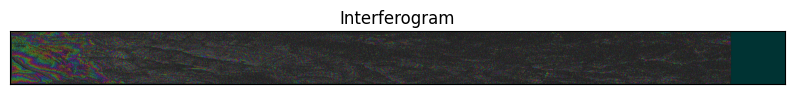

In [11]:

plot(
    "_results/interferogram.dim",
    i_band="i_ifg_IW1_VH_15Sep2023_03Sep2023",
    q_band="q_ifg_IW1_VH_15Sep2023_03Sep2023",
    coh_band="coh_IW1_VH_15Sep2023_03Sep2023",
    title = 'Interferogram',
    downsample=1,
    save_path="interferogram.png"
)


##### Deburst :Stitch bursts so the interferogram is continuous across the scene.

In [7]:
# deburst

polarization= 'VH'

deburst = topsar_deburst(interferogram, polarization)

Apply TOPSAR Deburst...

100% done.
TOPSAR Deburst applied!


In [24]:
#save product

save_product(deburst, "deburst")

Saving product to _results/deburst (BEAM-DIMAP)...
Product saved successfully.


'_results/deburst'

##### Multilooking: Reduces speckle

Generate, save output, and plot

In [9]:
# Multilook

multilook = multilooking(deburst, n_rg=3, n_az=1  )


100% done.


In [29]:
save_product(multilook, "multilook")

Saving product to _results/multilook (BEAM-DIMAP)...
Product saved successfully.


'_results/multilook'

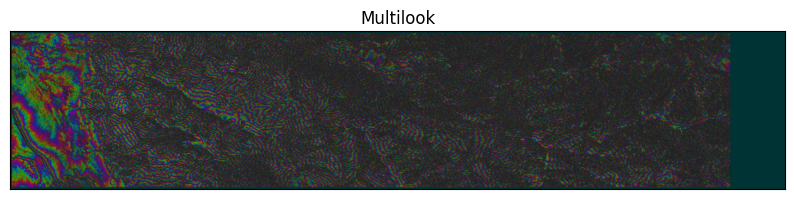

In [17]:
# plot the multilook 

plot(
    "_results/multilook.dim",
    i_band="i_ifg_IW1_VH_15Sep2023_03Sep2023",
    q_band="q_ifg_IW1_VH_15Sep2023_03Sep2023",
    coh_band="coh_IW1_VH_15Sep2023_03Sep2023",
    title = 'Multilook',
    downsample=1,
    save_path="phase_hsv.png"
)


##### Goldstein Phase Filtering:Denoise the interferometric phase

In [13]:
# goldstein correction

goldstein_phase= goldstein_phase_filtering(multilook)

Apply Goldstein Phase Filtering...

100% done.
Goldstein Phase Filtering applied!


In [14]:
save_product(goldstein_phase, 'goldstein_phase')

Saving product to _results/goldstein_phase (BEAM-DIMAP)...
Product saved successfully.


'_results/goldstein_phase'

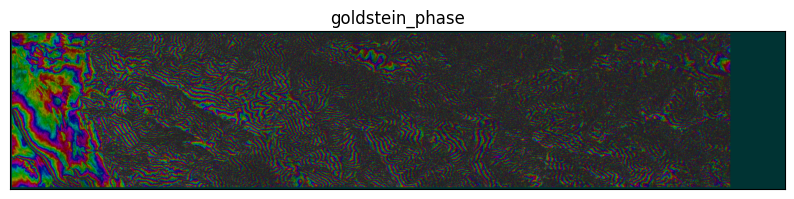

In [16]:
plot(
    "_results/goldstein_phase.dim",
    i_band="i_ifg_IW1_VH_15Sep2023_03Sep2023",
    q_band="q_ifg_IW1_VH_15Sep2023_03Sep2023",
    coh_band="coh_IW1_VH_15Sep2023_03Sep2023",
    title = 'goldstein_phase',
    downsample=1,
    save_path="goldstein_phase.png")